In [2]:
import numpy as np
import pandas as pd
from typing import List, Tuple, Union, Callable, Type
import warnings
from __future__ import annotations
from abc import ABC
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
#suppress warnings
warnings.filterwarnings('ignore')

In [3]:
def confusion_matrix(y_hat: np.array, y: np.array) -> np.array:
    num_class = len(np.unique(y))
    matrix = np.zeros((num_class, num_class))
    for y_true, y_hat in zip(y, y_hat):
        matrix[y_hat][y_true] += 1
    return matrix
    

def recall(y_hat: np.array, y: np.array) -> np.array:
    matrix = confusion_matrix(y_hat, y)
    n = len(matrix)
    recall = np.zeros(n)
    for i in range(n):
        recall[i] = matrix[i][i]/np.sum(matrix[:, i])
    return recall

def precision(y_hat: np.array, y: np.array) -> np.array:
    matrix = confusion_matrix(y_hat, y)
    n = len(matrix)
    precision = np.zeros(n)
    for i in range(n):
        precision[i] = matrix[i][i]/np.sum(matrix[i, :])
    return precision
    
def f_score(y_hat: np.array, y: np.array, to_class: boolen = True) -> np.array:
    y_hat_class = y_hat
    y_class = y
    if to_class:
        y_hat_class = proba_to_class(y_hat)
        y_class = proba_to_class(y)
    r = recall(y_hat_class, y_class)
    p = precision(y_hat_class, y_class)
    f_score = 2*p*r/(p + r)
    return f_score

def one_hot_encoding(y: np.array) -> np.array:
    n = len(np.unique(y))
    m = len(y)
    zeros = np.zeros((m, n))
    for zero, i in zip(zeros, y):
        zero[i] = 1
    return zeros.transpose()

def proba_to_class(y_hat: np.array) -> np.array:
    classes = np.argmax(y_hat, axis = 0)
    return classes

In [31]:
def sigmoid(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.exp(x)/(1 + np.exp(x))
        
def linear(x: Union[int, np.array]) -> Union[int, np.array]:
    return x

def softmax(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.divide(np.exp(x), np.sum(np.exp(x), axis = 0))

def relu(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.amax([x, np.zeros(x.shape)], axis= 0, initial=0)

def tanh(x: Union[int, np.array]) -> Union[int, np.array]:
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def mse(y_hat: np.array, y: np.array) -> np.array:
        return np.mean(np.square(y-y_hat))

In [32]:
class Loss(ABC):
    
    def __init__(self) -> None:
        pass
    
    def loss(self, y_hat: np.array, y: np.array) -> np.array:
        pass

class MSE(Loss):
    
    def __init__(self) -> None:
        super().__init__()
        
    def loss(self, y_hat: np.array, y: np.array) -> np.array:
        return np.mean(np.square(y-y_hat))
    
class Cross_entropy(Loss):
    
    def __init__(self) -> None:
        super().__init__()
        
    def loss(self, y_hat: np.array, y: np.array) -> np.array:
        epsilon = 1e-9
        return -np.mean(np.multiply(y, np.log(y_hat + epsilon)), axis = 1)
    

In [33]:
def dsigmoid(x: Union[int, np.array]) -> Union[int, np.array]:
    return sigmoid(x)*sigmoid(-x)

def dlinear(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.ones(x.shape)

def drelu(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.greater(x, 0).astype('int')

def dtanh(x: Union[int, np.array]) -> Union[int, np.array]:
    return 1 - np.square(tanh(x))

In [34]:
class Optimizer(ABC):
    
    def __init__(self, **kwargs: float) -> None:
        pass
        
    def fit_optimizer(self, w_opt: np.array,
                      b_opt: np.array, error_w: np.array,
                      error_b: np.array) -> Tuple[np.array]:
        pass

class Momentum(Optimizer):
    
    def __init__(self, lambd: float = 0.9) -> None:
        self.lambd = lambd
        
    def fit_optimizer(self, opt_w: np.array, 
                      opt_b: np.array, error_w: np.array,
                      error_b: np.array) -> Tuple[np.array]:
        opt_w = error_w + self.lambd * opt_w
        opt_b = error_b + self.lambd * opt_b
        
        update_w = opt_w
        update_b = opt_b
        
        return (opt_w, opt_b, update_w, update_b)
    

class RMSProp(Optimizer):
    
    def __init__(self, beta: float = 0.9) -> None:
        self.beta = beta
        
    def fit_optimizer(self, opt_w: np.array, 
                      opt_b: np.array, error_w: np.array,
                      error_b: np.array) -> Tuple[np.array]:
        opt_w = self.beta*opt_w + (1 - self.beta) * np.square(error_w)
        opt_b = self.beta*opt_b + (1 - self.beta) * np.square(error_b)
        
        update_w = np.divide(error_w, np.sqrt(opt_w))
        update_b = np.divide(error_b, np.sqrt(opt_b))
        
        return (opt_w, opt_b, update_w, update_b)
    

In [156]:
class Regularization(ABC):
    
    def __init__(self, alpha: float) -> None:
        self.alpha = alpha
        
    def regularize(self) -> float:
        pass
    
class L1(Regularization):
    
    def __init__(self, alpha: float) -> None:
        super().__init__(alpha)
        
    def regularize(self, weight: np.array) -> float:
        return self.alpha * np.sign(np.linalg.norm(weight, ord = 1))

class L2(Regularization):
    
    def __init__(self, alpha: float) -> None:
        super().__init__(alpha)
        
    def regularize(self, weight: np.array) -> float:
        return self.alpha * np.linalg.norm(weight, ord = 2)
    
class Dropout(Regularization):
    
    def __init__(self, alpha: float) -> None:
        super().__init__(alpha)
        
    def regularize(self, weight: np.array) -> float:
        return np.random.choice([0, 1], size=(weight.shape[0],), p=[self.alpha, 1 - self.alpha]).reshape(-1, 1)

In [269]:
class Model(ABC):
    
    def __init__(self):
        self.weights = []
        self.biases = []
        self.regularizations = []
        self.best_weights = []
        self.best_biases = []
        self.best_loss = None
        self.activation_functions = []
        self.n = None
        self.optimizer = None
        self.loss = None
        self.metric = None
        self.num_layers = 0
        self.metrics = {}
    
    def Input(self, shape: Tuple = (None, None)) -> int:
        pass
    
    def Output(self, shape: Tuple = (None, None)) -> int:
        pass
    
    def fit(self, X: np.array, y: np.array) -> Model:
        return self
    
    def add(self, nodes: int, activation_function: Callable[[Union[int, np.array]], Union[int, np.array]],
            weight: np.array) -> None:
        pass
    
    def complie(self, optimzer: Type[Optimizer]) -> None:
        pass
    
    def predict(self, x: np.array) -> np.array:
        pass
    
    def initialize(self) -> None:
        pass

In [284]:
class MLP(Model):
    
    def __init__(self) -> None:
        super().__init__()
        
    def Input(self, shape: Tuple = (None, None)) -> int:
        self.n = shape[1]
        
    def Output(self, shape: Tuple = (None, None)) -> int:
        pass
    
    def fit(self, X: np.array, y: np.array, eta: float,
            regularization: Type[Regularization] = None, batch_size: int = 1,
            epochs: int = 1, verbose: int = 1, verbose_step: int = 10) -> MLP:
        
        opt_b = [np.zeros(bias.shape) for bias in self.biases]
        opt_w = [np.zeros(weight.shape) for weight in self.weights]
        
        y_hat = self.predict(X) 
        self.best_loss = np.mean(self.loss().loss(y_hat, y))
        
        for epoch in range(epochs):
            dim = min(sorted(y.shape, reverse = True)[1:] or [1])
            concat = np.concatenate([X.transpose(), y.transpose().reshape(-1, dim)], axis = 1)
            np.random.shuffle(concat)
            X_shuffle = concat[:, :X.shape[0]].transpose()
            y_shuffle = concat[:, X.shape[0]:].transpose()
            
            batches_X = [np.array(X_shuffle[:, i: i + batch_size]) for i in range(0, len(X[0]), batch_size)]
            batches_y = [y_shuffle[:, i: i + batch_size] for i in range(0, len(y), batch_size)]
            for batch_X, batch_y in zip(batches_X, batches_y):
                
                n = len(batch_X[0])
                error_b, error_w = self.backprop(batch_X, batch_y)                    
                
                for i in range(len(self.weights)):
                    
                    if self.optimizer is not None:
                        opt_w[i], opt_b[i], update_w, update_b = self.optimizer.fit_optimizer(
                            opt_w[i], opt_b[i], error_w[i], error_b[i])
                        
                    else:
                        update_w = error_w[i]
                        update_b = error_b[i]
                        
                    if regularization and type(regularization).__name__ == "Dropout":
                        self.weights[i] -= regularization.regularize(self.weights[i])/n
                        self.biases[i] -= regularization.regularize(self.biases[i])/n
                        
                    self.weights[i] -= eta*update_w/n
                    self.biases[i] -= eta*update_b/n
                        
                    w = 'w' + str(i)
                    b = 'b' + str(i)
                    if w not in self.metrics and b not in self.metrics:
                        self.metrics[w] = [np.linalg.norm(self.weights[i])]
                        self.metrics[b] = [np.linalg.norm(self.biases[i])]
                    else:
                        self.metrics[w].append(np.linalg.norm(self.weights[i]))
                        self.metrics[b].append(np.linalg.norm(self.biases[i]))
                
            y_hat = self.predict(X)
            loss_hat = np.mean(self.loss().loss(y_hat, y))
            if verbose == 1 and epoch % int(max(1, epochs//verbose_step)) == 0:
                metric_score = self.metric(y_hat, y)
                print(f'{type(self.loss()).__name__}: {loss_hat}  ----- {self.metric.__name__}: {np.mean(metric_score)}')
            if loss_hat < self.best_loss:
                self.best_loss = loss_hat
                self.best_weights = self.weights
                self.best_biases = self.biases
                        
                        
                
    def backprop(self, X: np.array, y: np.array) -> List[np.array]:
        error_b = [np.zeros(bias.shape) for bias in self.biases]
        error_w = [np.zeros(weight.shape) for weight in self.weights]
        
        activation = X
        activations = [X]
        zs = []
        dropouts = np.full(self.num_layers - 1, None)
        
        for i, (weight, fun, bias, regularization) in enumerate(zip(self.weights, self.activation_functions,
                                                     self.biases, self.regularizations)):
            z = np.dot(weight, activation) + bias.reshape(-1,1)
            activation = fun(z)
            
            if regularization and type(regularization).__name__ == "Dropout":
                dropout = regularization.regularize(weight)
                z = np.multiply(z, dropout)
                activation = np.multiply(activation, dropout)
                dropouts[i] = dropout
            zs.append(z)
            activations.append(activation)
        
        
        error = activations[-1] - y
        
        error_b[-1] = np.dot(error, np.ones(error.shape[1]).transpose())
        error_w[-1] = np.dot(error, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            dname = 'd' + self.activation_functions[-l].__name__
            dz = globals()[dname](z)
            if self.regularizations[-l] and type(self.regularizations[-l]).__name__ == "Dropout":
                dz = np.multiply(dz, dropouts[-l])
                
            error = np.multiply(np.dot(self.weights[-l+1].transpose(), error), dz)
            error_b[-l] = np.dot(error, np.ones(error.shape[1]).transpose())
            error_w[-l] = np.dot(error, activations[-l-1].transpose())
            
        return error_b, error_w
            
    def add(self, nodes: int, activation_function: Callable[[Union[int, np.array]], Union[int, np.array]],
            weight: np.array = None, bias: np.array = None,
            regularization: Type[Regularization] = None) -> None:
        
        if weight is None and bias is None:
            weight, bias  = self.initialize1(nodes, activation_function.__name__)
            
        n_w, m_w = weight.shape
        
        weight = weight.transpose()
        
        self.weights.append(weight)
        self.biases.append(bias)
        self.regularizations.append(regularization)
        self.best_weights.append(weight)
        self.best_biases.append(bias)
        self.activation_functions.append(activation_function)
        self.n = nodes
        
    def complie(self, loss: Type[Loss] = None, optimizer: Type[Optimizer] = None, metric = None) -> None:
        self.num_layers = len(self.weights) + 1
        self.optimizer = optimizer
        self.loss = loss
        self.metric = metric
        
    
    def predict(self, x: np.array) -> np.array:
        for weight, fun, bias in zip(self.best_weights, self.activation_functions, self.best_biases):
            x = fun(np.dot(weight, x) + bias.reshape(-1,1))
        return x     
    
    
    def initialize(self, m: int) -> None:
        weight = np.random.uniform(-0.5, 0.5, size = (self.n, m))
        bias = np.random.uniform(-0.5, 0.5, size = (m))
        return weight, bias
    
    def initialize1(self, m: int, activation_function: str) -> None:
        if activation_function in ['sigmoid', 'tanh', 'softmax', 'linear']:
            limit = np.sqrt(6/(self.n + m))
            weight = np.random.uniform(-limit, limit, size = (self.n, m))
            bias = np.random.uniform(-limit, limit, size = (m))
        if activation_function in ['relu']:
            limit = np.sqrt(2/(self.n + m))
            weight = np.random.randn(self.n, m)*limit
            bias = np.random.randn(m)*limit
        return weight, bias

In [281]:
rings3_regular_test = pd.read_csv('mio1/classification/rings3-regular-test.csv')
rings3_regular_train = pd.read_csv('mio1/classification/rings3-regular-training.csv')
rings5_regular_test = pd.read_csv('mio1/classification/rings5-regular-test.csv')
rings5_regular_train = pd.read_csv('mio1/classification/rings5-regular-training.csv')
multimodal_large_training = pd.read_csv('mio1/regression/multimodal-large-training.csv', usecols = ['x', 'y'])
multimodal_large_test = pd.read_csv('mio1/regression/multimodal-large-test.csv', usecols = ['x', 'y'])

In [46]:
data_train = rings3_regular_train
data_test = rings3_regular_test

X_train = np.array(data_train[['x', 'y']])
y_train = np.array(data_train['c'])
y_train = y_train.astype('int32')
y_train_one = one_hot_encoding(y_train)

X_test = np.array(data_test[['x', 'y']])
y_test = np.array([data_test['c']])
y_test = y_test.astype('int32')
y_test_one = one_hot_encoding(y_test)

Cross_entropy: 0.5933705791975094  ----- f_score: 0.3162333587096832
Cross_entropy: 0.22496251178228355  ----- f_score: 0.7348131360482805
Cross_entropy: 0.19338487274904717  ----- f_score: 0.7704102982939177
Cross_entropy: 0.18374126549689143  ----- f_score: 0.782539122676937
Cross_entropy: 0.16831539953190286  ----- f_score: 0.80700015294
Cross_entropy: 0.20408313801840486  ----- f_score: 0.7327890131759807
Cross_entropy: 0.14269329574455392  ----- f_score: 0.8710478816876207
Cross_entropy: 0.1482163417189537  ----- f_score: 0.8108949554519587
Cross_entropy: 0.13762515329375377  ----- f_score: 0.8514717385013789
Cross_entropy: 0.12768519166829087  ----- f_score: 0.8621089015278017
Train Cross_entoropy: [4.00911553 1.44934086 1.09044132]
Test Cross_entopopy: [4.69352202 1.75714152 1.23850708]
Confusion matrix 
[[326.  25.   5.]
 [ 20. 672. 100.]
 [ 70.  72. 710.]]
Test F-score 0.8524585888835384


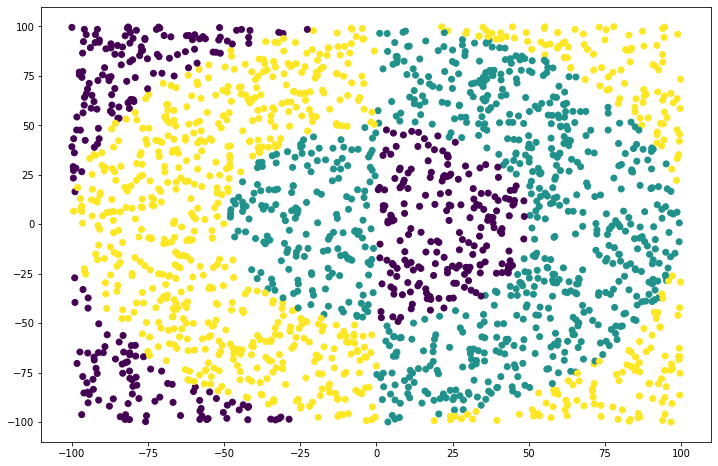

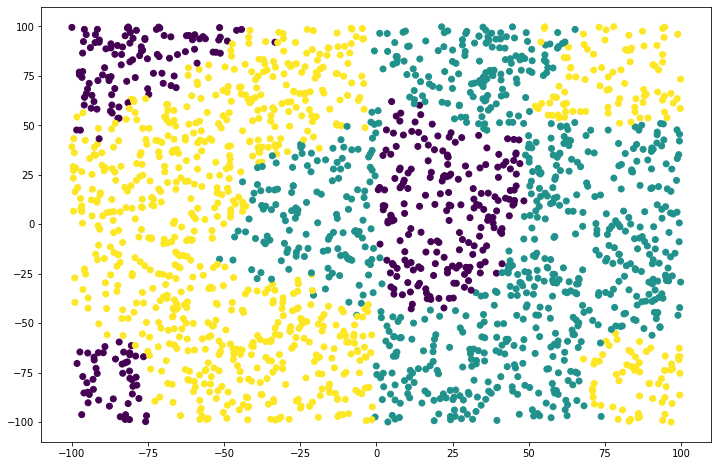

In [60]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(100, tanh)
mlp.add(3, softmax)
mlp.complie(loss = Cross_entropy, metric=f_score, optimizer=Momentum(0.9))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.001, batch_size= 128,
        epochs= 10000, regularization = L2(0.003))

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)


print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0], to_class = False ))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = rings3_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = y_hat_test_class)
plt.show()

In [62]:
data_train = rings5_regular_train
data_test = rings5_regular_test

X_train = np.array(data_train[['x', 'y']])
y_train = np.array(data_train['c'])
y_train = y_train.astype('int32')
y_train_one = one_hot_encoding(y_train)

X_test = np.array(data_test[['x', 'y']])
y_test = np.array([data_test['c']])
y_test = y_test.astype('int32')
y_test_one = one_hot_encoding(y_test)

Cross_entropy: 0.41990934540698194  ----- f_score: 0.2264527978782762
Cross_entropy: 0.19902557962807327  ----- f_score: 0.5790292221917849
Cross_entropy: 0.1789695177493201  ----- f_score: 0.6364489323798568
Cross_entropy: 0.16046372344441395  ----- f_score: 0.717667414468159
Cross_entropy: 0.1441316777080684  ----- f_score: 0.7363698042794334
Cross_entropy: 0.13454412771186217  ----- f_score: 0.761138755690721
Cross_entropy: 0.12415483281353665  ----- f_score: 0.7745846809717283
Cross_entropy: 0.11143931308836971  ----- f_score: 0.8304696111156913
Cross_entropy: 0.10537636924304283  ----- f_score: 0.8057887833893259
Cross_entropy: 0.09495221438399609  ----- f_score: 0.8468678394626714
Train Cross_entoropy: [11.62797871  8.34594693  6.15920466  3.72091784  6.79389963]
Test Cross_entopopy: [14.31647718  8.90619241  5.45343183  3.76420189  9.15337583]
Confusion matrix 
[[104.  39.   0.   0.   7.]
 [  1. 258.  72.   0.   0.]
 [  0.  12. 441. 100.   0.]
 [  0.   0. 127. 502.  28.]
 [  3. 

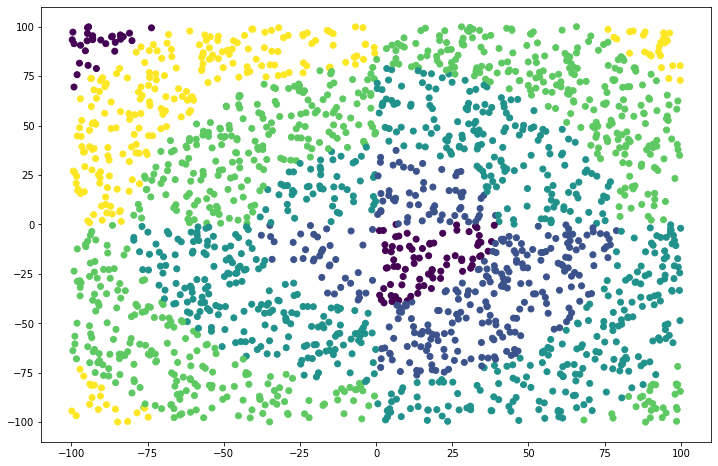

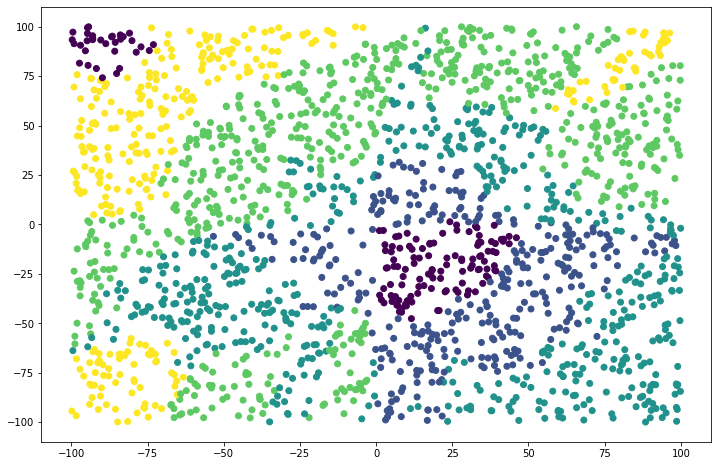

In [63]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(100, tanh)
mlp.add(5, softmax)
mlp.complie(loss = Cross_entropy, metric=f_score, optimizer=Momentum(0.9))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.001, batch_size= 128,
        epochs= 10000, regularization = L2(0.003))

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)

print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0], to_class=False))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings5_regular_test['x'], rings5_regular_test['y'], c = rings5_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings5_regular_test['x'], rings5_regular_test['y'], c = y_hat_test_class)
plt.show()

In [282]:
data_train = rings3_regular_train
data_test = rings3_regular_test

X_train = np.array(data_train[['x', 'y']])
y_train = np.array(data_train['c'])
y_train = y_train.astype('int32')
y_train_one = one_hot_encoding(y_train)

X_test = np.array(data_test[['x', 'y']])
y_test = np.array([data_test['c']])
y_test = y_test.astype('int32')
y_test_one = one_hot_encoding(y_test)

Cross_entropy: 0.39202822862902836  ----- f_score: 0.3962525680492179
Cross_entropy: 0.254961091414176  ----- f_score: 0.6586269055708757
Cross_entropy: 0.262702335436977  ----- f_score: 0.655266644553413
Cross_entropy: 0.26067826432238184  ----- f_score: 0.6399880227413343
Cross_entropy: 0.25914626584633865  ----- f_score: 0.6407660132196517
Cross_entropy: 0.24729643226712375  ----- f_score: 0.6614984322041672
Cross_entropy: 0.2326683894375244  ----- f_score: 0.6762372263497438
Cross_entropy: 0.22757848678439738  ----- f_score: 0.6809767914511347
Cross_entropy: 0.21045527349572904  ----- f_score: 0.7332053124248777
Cross_entropy: 0.2125116097037675  ----- f_score: 0.7383564128405714
Train Cross_entoropy: [1.9046232 1.4444669 1.1929709]
Test Cross_entopopy: [2.24839447 1.75340659 1.3805465 ]
Confusion matrix 
[[341.  44. 137.]
 [ 18. 600. 130.]
 [ 57. 125. 548.]]
Test F-score 0.7424996473010017


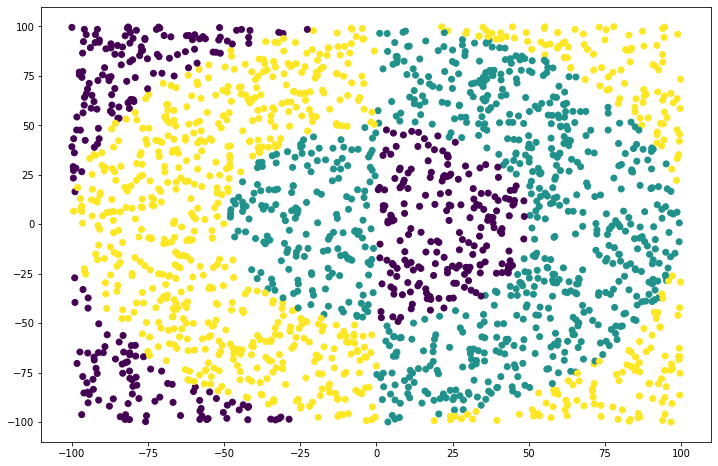

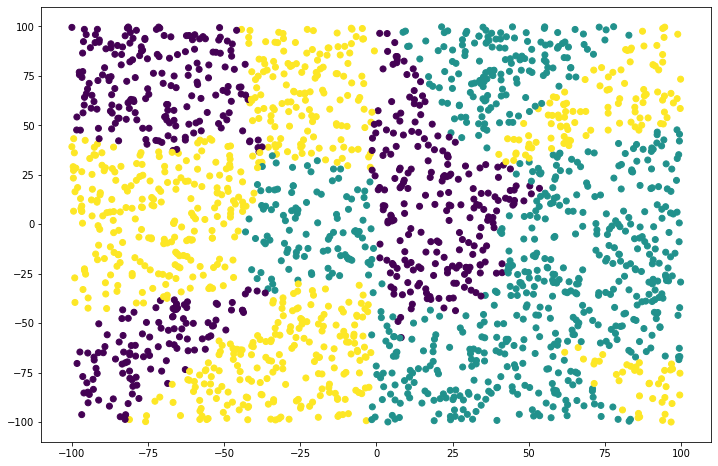

In [289]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(100, tanh, regularization = Dropout(0.1))
mlp.add(3, softmax)
mlp.complie(loss = Cross_entropy, metric=f_score, optimizer=Momentum(0.9))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.001, batch_size= 128,
        epochs= 10000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)

print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0], to_class=False))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = rings3_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = y_hat_test_class)
plt.show()

In [252]:
mlp.regularizations

[None, <__main__.Dropout at 0x277da02e2e0>, None]

array([None, None, None], dtype=object)

In [290]:
def compare_reg(*layers, name, out, last_fun, batch_size, epochs):

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(name, fontsize=18, c = 'w')

    activation = [linear, sigmoid, relu, tanh]
    etas = [0.001, 0.001, 0.0001, 0.001]
    i = 0
    for act, eta in zip(activation, etas):
        start_time = time.time()
        #print(act.__name__.upper())
        mlp = MLP()
        mlp.Input(shape = (None, 1))
        for layer in layers:
            mlp.add(layer, act)
        mlp.add(out, last_fun)
        mlp.complie(loss = MSE, metric = mse, optimizer = Momentum(0.9))
        mlp.fit(X_train, y_train, eta = eta, batch_size = batch_size, epochs=epochs, 
                verbose = 2, regularization = L2(0.003))

        y_hat_train = mlp.predict(X_train)
        y_hat_test = mlp.predict(X_test)
        #print(f'Train MSE: {mse(y_hat_train, y_train)}')
        #print(f'Test MSE: {mse(y_hat_test, y_test)}')
        #print(f'Time: {time.time() - start_time}')
        #print()
        ax = plt.subplot(2, 2, i + 1) 
        i += 1
        plt.scatter(X_test, y_hat_test, label="y_hat_test")
        plt.scatter(X_test, y_test, label="y_true")
        title = act.__name__+ \
        " Test MSE: " + str(round(mse(y_hat_test, y_test), 4)) +\
        " Time: " + str(round(time.time() - start_time, 2))
        ax.set_title(title, color = 'w')
        ax.set_xlabel("")
        
def compare_class(*layers, name, inp, out, last_fun, batch_size, epochs):

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(name, fontsize=18, c = 'w')

    activation = ["orginal", sigmoid, relu, tanh]
    etas = [0, 0.001, 0.001, 0.001]
    i = 0
    for act, eta in zip(activation, etas):
        if act != "orginal":
            start_time = time.time()
            mlp = MLP()
            mlp.Input(shape = (None, inp))
            for layer in layers:
                mlp.add(layer, act)
            mlp.add(out, last_fun)
            mlp.complie(loss = Cross_entropy, metric=f_score, optimizer = Momentum(0.9))
            mlp.fit(X_train.transpose(), y_train_one, eta = eta, batch_size= batch_size,
                    epochs= epochs, verbose = 2, regularization = L2(0.003))

            y_hat_train = mlp.predict(X_train.transpose())
            y_hat_test = mlp.predict(X_test.transpose())
            y_hat_train_class = proba_to_class(y_hat_train)
            y_hat_test_class = proba_to_class(y_hat_test)

        ax = plt.subplot(2, 2, i + 1) 
        i += 1
        if act == "orginal":
            plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = rings3_regular_test['c'])
        else:
            plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = y_hat_test_class)
            title = act.__name__+ \
        " Test F-score: " + str(round(np.mean(f_score(y_hat_test_class, y_test[0], to_class = False)), 4)) +\
        " Time: " + str(round(time.time() - start_time, 2))
            ax.set_title(title, color = 'w')
        ax.set_xlabel("")